In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import minimize
from scipy.optimize import curve_fit, differential_evolution

# import cupy as cp

In [8]:
t_min = 0
t_end = 24 * 5

In [21]:
data = pd.read_csv('experiment.csv')
data = [[0] + data[str(i)].to_list()[:6] for i in range(1, 4)]
data = [[data[0][i], data[1][i], data[2][i]] for i in range(6)]
data = np.cumsum(data, axis=0)

mean_srip_data = np.mean(data, axis=1)  # 各時間点での平均値
std_srip_data = np.std(data, axis=1)  # 各時間点での標準偏差

t_data = np.array([24*i for i in range(6)])

In [26]:
def model_for_fit(t, y, K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t):
    X, DNA, RNA, SRIP = y
    if X < 0:
        X = 0
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser) - k_t * SRIP
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_sRNA * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X

    # if dXdt < 0:
    #     dXdt = 0
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

In [27]:
params_fix = [
    # P,             X_max, Ser, k_DNA,        
    [math.log(2)/24, 1.3e6, 4.0e-4,   math.log(2)/24]
    ]

initial_param = [
    #K_Ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t
    [1e-5,  3e-2,   3e-2,   1e-2, 2e+3,  1e-2]
    #fix,   fix,    fix,    TBD,  fix,   TBD
    ]

bounds = [(1e-6, 5e-4), (0, 1e+1), (0, 1e+5), (0, 1e+5), (0, 1e+5), (1e-2, 1e+1)]

P, X_max, Ser, k_DNA = params_fix[0]
X_0 = 2e5
DNA_0 = 2.0 * 1e11 / X_0 * 0.8
RNA_0 = 0.0  # Okumura
SRIP_0 = 0.0  # SRIPの初期値を適切に設定してください
y0 = [X_0, DNA_0, RNA_0, SRIP_0] # X, DNA, RNA, SRIP

In [28]:
def model(t, y, P, X_max, Ser, K_ser, k_DNA, k_sRNA, k_dRNA, k_vp, K_RNA, k_t):
    X, DNA, RNA, SRIP = y
    if X < 0:
        X = 0
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser) - k_t * SRIP
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_sRNA * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

最適化されたパラメータ(full): [1.00000007e-06 1.30321654e-02 1.36786524e+00 1.92249485e-02
 2.85081686e+03 4.30861476e-02]


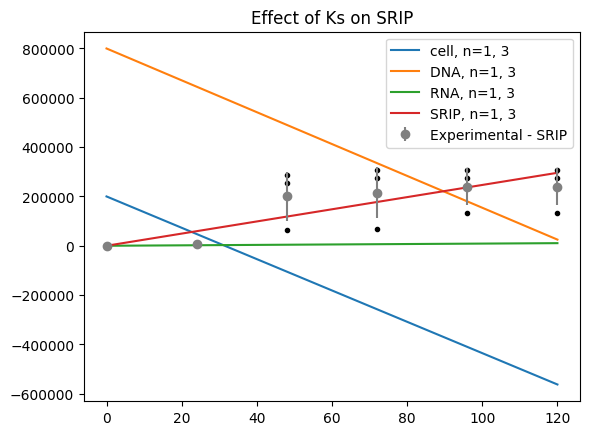

In [30]:
def fit_function(t, K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t):
    sol = solve_ivp(model_for_fit, [t_min, t_end], y0, args=(K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=t, method='RK45')
    
    return sol.y[-1]

popt_clip, _ = curve_fit(fit_function, t_data, (data[:, 0] + data[:, 2])/2, p0=initial_param[0], bounds=np.array(bounds).T)
# popt_full, _ = curve_fit(fit_function, t_data, mean_srip_data, p0=initial_param[0], bounds=np.array(bounds).T)

# print('initial:', initial_param)
print('最適化されたパラメータ(full):', popt_full)

results = []

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t = popt_clip
# results.append(solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45'))
results.append(solve_ivp(model_for_fit, [t_min, t_end], y0, args=(K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=[t_min, t_end], method='RK45'))
# K_ser, k_sRNA, k_dRNA, k_vp, K_RNA, k_t = popt_full
# results.append(solve_ivp(model, [t_min, t_end], y0, args=(P, X_max, Ser, K_ser, k_DNA, k_sRNA, k_dRNA, k_vp, K_RNA, k_t), t_eval=np.linspace(t_min, t_end, 1000), method='RK45'))

ax.plot(results[0].t, results[0].y[0], label=f'cell, n=1, 3')
ax.plot(results[0].t, results[0].y[1], label=f'DNA, n=1, 3')
ax.plot(results[0].t, results[0].y[2], label=f'RNA, n=1, 3')
ax.plot(results[0].t, results[0].y[3], label=f'SRIP, n=1, 3')

# ax.plot(results[1].t, results[1].y[0], label=f'n=1, 2, 3')
# ax.plot(results[1].t, results[1].y[3], label=f'n=1, 2, 3')

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.', color='black')

ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP', color='gray')

ax.set_title('Effect of Ks on SRIP')
# ax.set_ylim(0, 5e5)
ax.legend()